# A Hybrid Movie Recommendation System

### Group members: Guanyu Chen, Zhuowei Cheng, Jingyi Xiao, Jing Xu

## 1. Introduction

Various data collection approaches expose people to massive information daily. Making decisions efficiently facing oceans of information for information receivers as well as distributing effective information to appropriate targets for information distributors is not an easy task. The recommendation system that utilizes the power of machines was proposed to select the most possible important information targeted for specific groups. The recommendation system is a way to predict users' preference on items and then conduct recommendation. The recommendation system has been everywhere such as Amazon's recommended items, Youtube's video suggestions, online shopping advertisement just to name a few. One prominent application of the recommendation system is movie recommender, which forecasts users' preference on movies with data depicting movie, user and their interaction.

There are several primary types of movie recommender systems. A popularity based recommendation system offers suggestions based on overall user ratings and recommends movies with high ratings to users. The more popular a movie, the higher possibility of it being recommended. Content based recommender suggests similar movies to users according to a given movie. Similarity is often measured based on movie meta data such as genres, actors, directors, descriptions and so on. Another type, collaborative filtering, provides recommendation based on the match between users' interest. These recommendation systems have their own strengths and weakness. Thus, hybrid systems which contain at least two simple recommenders were proposed to overcome drawbacks of a single recommendation system. Advanced techniques such as neural network have also been used to build recommendation systems.

This project focused on constructing an informative movie recommender to provide valuable movie suggestions tailored to specific users as well as considering movie contents and popularity.

## 2. Data

The data we use are from TMDB datasets which contain around 5,000 movies and TV series (can be downloaded at https://www.kaggle.com/tmdb/tmdb-movie-metadata). The TMDB datasets include movie metadata (such as title, overview, genres, release date, revenues and so on), credits (including cast and crew information) and user ratings information.

After data pre-processing, two dataframes `movies` and `ratings` are created. The dataframe `movies` characterizes movie properties such as movie titles, release dates, genres, keywords, overviews, taglines, casts, directors and others. The dataframe `ratings` contains user-movie interaction information, that is users' ratings. 

In [1]:
# !pip install --upgrade pip
!pip install seaborn

In [18]:
# !pip install numpy cython
!git clone https://github.com/NicolasHug/surprise.git
!cd surprise
!python setup.py install
# !pip install surprise
# !pip install wordcloud
# !conda install -c conda-forge scikit-surprise

xcrun: error: invalid active developer path (/Library/Developer/CommandLineTools), missing xcrun at: /Library/Developer/CommandLineTools/usr/bin/xcrun
/bin/sh: line 0: cd: surprise: No such file or directory
python: can't open file 'setup.py': [Errno 2] No such file or directory
/bin/sh: conda: command not found


In [84]:
%matplotlib inline
import pandas as pd ## call pandas functions using "pd"
import numpy as np  ## call numpy functions using "np"
import matplotlib.pyplot as plt
from ast import literal_eval
import ast
import seaborn as sns
from scipy import stats
from datetime import datetime
from IPython.display import Markdown
from os.path import join
from os.path import exists
import function as f
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random
from surprise import Reader, Dataset, SVD, evaluate
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
from datetime import datetime
from IPython.display import Markdown
from IPython.display import Image

Read in movie information and conduct preprocessing.

In [4]:
movie_meta = pd.read_csv("Data/movies_metadata.csv")
link = pd.read_csv('Data/links_small.csv')
keywords = pd.read_csv('Data/keywords.csv')
credits = pd.read_csv('Data/credits.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


`f` is a python module that we created to preprocess the data. It consists of various functions, for instance, to join `pandas` data frames, get values from a dictionary, text clean, drop duplicates and etc. 

`movies` below is the data frame that we will work on for the rest of the report.

In [5]:
movies = f.create_movie(movie_meta, link, keywords, credits)
movies.index = range(len(movies))
movies['popularity'] = movies['popularity'].astype(float)
links_small = link[link['tmdbId'].notnull()]['tmdbId'].astype('int')

There are 9082 movie items and 15 attributes in `movies`. 

In [6]:
movies.shape

(9082, 15)

In [7]:
movies.columns

Index(['id', 'title', 'popularity', 'vote_count', 'vote_average',
       'release_date', 'genres', 'keywords', 'original_language', 'overview',
       'production_companies', 'tagline', 'cast', 'director', 'features'],
      dtype='object')

Read rating data and conduct preprocessing.

In [8]:
# read rating data and preprocessing
ratings = pd.read_csv('Data/ratings_small.csv')
ratings['timestamp'] = ratings['timestamp'].apply(datetime.fromtimestamp)
ratings['year'] = ratings['timestamp'].dt.year
ratings['month'] = ratings['timestamp'].dt.month
# ratings.head()

# sort data by timestamp
ratings = ratings.sort_values('timestamp')
# ratings.head()

In [9]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'year', 'month'], dtype='object')

Create a search table `combine_df` to link movie titles, *tmdbId* from `movies` and *id* from `ratings`.

In [10]:
movies_title = movie_meta.loc[movie_meta.title.drop_duplicates().index]
movies_subset = (movies_title.loc[:, ['id', 'title']].copy().
                 rename(index=str, columns={"id": "tmdbId", "title": "title"}))
# create the searching table
df = link.loc[links_small.index]
df.tmdbId = df.tmdbId.astype('int64')
combine_df = df.join(movies_subset.set_index('tmdbId'), on = 'tmdbId', how = 'inner')
combine_df.head()

,movieId,imdbId,tmdbId,title
0,1,114709,862,Toy Story
1,2,113497,8844,Jumanji
2,3,113228,15602,Grumpier Old Men
3,4,114885,31357,Waiting to Exhale
4,5,113041,11862,Father of the Bride Part II


In [11]:
del movies_title, movies_subset, df, keywords, credits

Here, a few virtual users are created to test the final hybrid recommender.

In [12]:
# test data
user1 = [12324, {"Toy Story": 4, "Grumpier Old Men":3.5, "Waiting to Exhale": 4, 
                 'Sabrina': 3.5, 'Heat': 2, 'Money Train':2.5}]
user2 = [307, {"The Endless Summer": 4, "East of Eden":3, "Rio Bravo": 4, 
                 'The Bridges of Madison County': 3.5, 'Dead Man Walking': 2}]
user3 = [233333, {"The Endless Summer": 4, "East of Eden":3, "Rio Bravo": 4, 
                 'The Bridges of Madison County': 3.5, 'Dead Man Walking': 2}]
user4 = [233333, {"d": 4, "dasfsaf":3, "ddd": 4, 
                 'aaa': 3.5, 'cccccc': 2}]

## 3. EDA

A brief numeric summary of `movies` shows that the average votes is 6.36 on a scale of 0-10 with a standard deviation of 1.04. There are averagely 439.05 votes for a movie. The high standard deviation of `vote_count`, 996.16, shows the great variability of vote counts. 

In [13]:
# summary
movies.describe()

,id,popularity,vote_count,vote_average
count,9082.000000,9082.000000,9082.000000,9082.000000
mean,38710.463885,7.268905,439.050870,6.362178
std,62123.411079,9.372314,996.156492,1.038748
min,2.000000,0.000004,0.000000,0.000000
25%,9446.250000,2.954521,29.000000,5.800000
50%,15775.000000,6.418871,96.000000,6.500000
75%,39010.250000,9.861742,365.750000,7.000000
max,416437.000000,547.488298,14075.000000,10.000000


In [14]:
temp = movies.copy()

### Genres

One variable that can be interesting to explore is `genres`. How many genres are there in the dataset? How many movies in each genre? Does popularity change by genre frequency? 

First the number of genres is extracted.

In [15]:
s = temp.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
genres_df = temp.drop('genres', axis=1).join(s)
genres_df['genre'].value_counts().shape[0]

20

Counts for each genre are showed below.

In [16]:
genres_counts = pd.DataFrame(genres_df['genre'].value_counts()).reset_index()
genres_counts.columns = ['genre', 'movies']
genres_counts

,genre,movies
0,drama,4644
1,comedy,3373
2,thriller,1989
3,romance,1834
4,action,1752
5,crime,1255
6,adventure,1197
7,horror,916
8,family,851
9,science fiction,850


Does popularity change by genre frequency? The conditional boxplot shows that popularity does not change by genre frequency. Apparently, the genre 'Foreign' is clearly less popular, but there are no obvious differences in popularity among different genres.

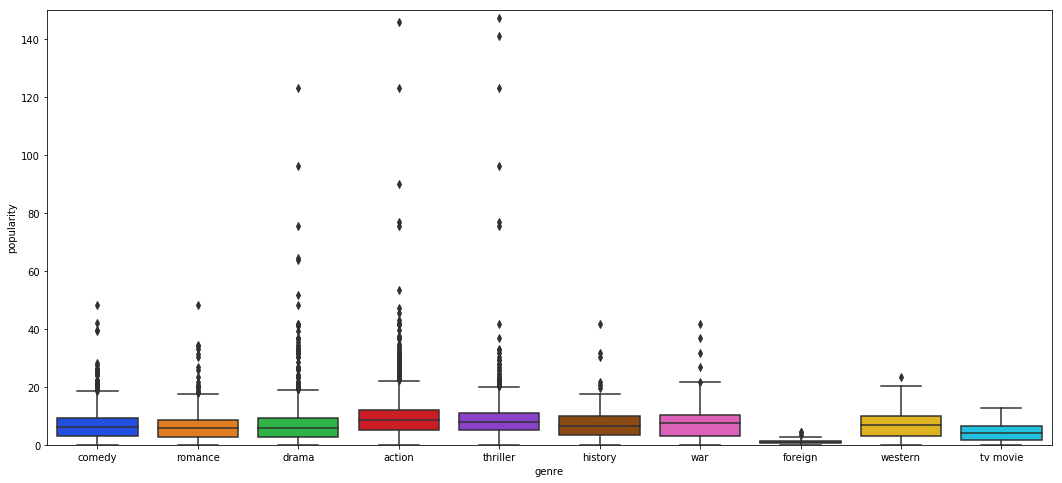

In [17]:
top_genres=['drama', 'comedy', 'thriller', 'romance', 'action', 'history',  'war', 'western', 'foreign', 'tv movie']
plt.figure(figsize=(18,8))
sns.boxplot(x='genre', y='popularity', data=genres_df[(genres_df['genre'].isin(top_genres))], palette="bright")
plt.ylim(0,150)
plt.show()

### Directors

Director information can be useful. The top 10 productive directors are listed below. 

In [18]:
temp['director'].value_counts().shape[0]
temp['director'].value_counts()
genres_counts = pd.DataFrame(temp['director'].value_counts()).reset_index()
genres_counts.columns = ['director', 'movies']
genres_counts.head(10)

,director,movies
0,woody_allen,42
1,alfred_hitchcock,38
2,steven_spielberg,30
3,clint_eastwood,30
4,martin_scorsese,29
5,steven_soderbergh,25
6,sidney_lumet,25
7,,24
8,robert_altman,23
9,werner_herzog,23


In [19]:
sim_director1 = temp[temp['director']=='woody_allen']
sim_director2 = temp[temp['director']=='alfred_hitchcock']
sim_director3 = temp[temp['director']=='clint_eastwood']

Do movies from the same director usually have similar `vote_count` and `vote_average`? Here, the top 3 directors are investigated. In general, the standard deviations of `vote_count` and `vote_average` of each director are smaller than the overall standard deviations. This means that movies from the same director are more likely to receive similar ratings. The top 3 directors also receive higher average ratings (i.e. `vote_average`) than average.

In [20]:
sim_director1.describe()

,id,popularity,vote_count,vote_average
count,42.000000,42.000000,42.000000,42.000000
mean,29483.904762,8.108443,337.666667,6.783333
std,58308.797157,2.997750,407.496321,0.539158
min,116.000000,2.916982,49.000000,5.600000
25%,9520.500000,5.968568,113.250000,6.425000
50%,11319.500000,7.504731,172.500000,6.750000
75%,18366.750000,9.576351,337.250000,7.175000
max,282984.000000,18.146043,2049.000000,7.800000


In [21]:
sim_director2.describe()

,id,popularity,vote_count,vote_average
count,38.000000,38.000000,38.000000,38.000000
mean,9577.710526,8.061629,326.421053,7.018421
std,11760.094693,6.251144,492.371406,0.743932
min,213.000000,1.581063,16.000000,5.300000
25%,549.000000,4.862289,60.250000,6.700000
50%,3467.000000,6.447605,146.000000,7.150000
75%,14585.500000,9.122593,333.500000,7.500000
max,36049.000000,36.826309,2405.000000,8.300000


In [22]:
sim_director3.describe()

,id,popularity,vote_count,vote_average
count,30.000000,30.000000,30.000000,30.000000
mean,20018.100000,8.902751,715.233333,6.676667
std,36757.517119,3.461430,1031.435213,0.738910
min,33.000000,3.793634,39.000000,5.200000
25%,4150.000000,6.060639,149.750000,6.300000
50%,10184.500000,8.542936,293.500000,6.600000
75%,17115.000000,10.684329,712.750000,7.300000
max,190859.000000,19.228561,4600.000000,7.800000


Is there any correlation between directors and movie genres? Most movies of a director tend to concentrate on several genres.

In [23]:
s = sim_director1.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
genres_df1 = sim_director1.drop('genres', axis=1).join(s)
genres_df1['genre'].value_counts().shape[0]
genres_counts = pd.DataFrame(genres_df1['genre'].value_counts()).reset_index()
genres_counts.columns = ['genre', 'movies']
genres_counts

,genre,movies
0,comedy,38
1,drama,21
2,romance,20
3,mystery,4
4,crime,4
5,thriller,4
6,action,3
7,fantasy,2
8,history,1
9,music,1


In [24]:
s = sim_director2.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
genres_df2 = sim_director2.drop('genres', axis=1).join(s)
genres_df2['genre'].value_counts().shape[0]
genres_counts = pd.DataFrame(genres_df2['genre'].value_counts()).reset_index()
genres_counts.columns = ['genre', 'movies']
genres_counts

,genre,movies
0,thriller,31
1,mystery,21
2,drama,20
3,crime,15
4,romance,4
5,comedy,4
6,war,3
7,adventure,2
8,horror,2
9,action,1


In [25]:
s = sim_director3.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
genres_df3 = sim_director3.drop('genres', axis=1).join(s)
genres_df3['genre'].value_counts().shape[0]
genres_counts = pd.DataFrame(genres_df3['genre'].value_counts()).reset_index()
genres_counts.columns = ['genre', 'movies']
genres_counts

,genre,movies
0,drama,23
1,crime,12
2,thriller,11
3,action,9
4,western,6
5,war,4
6,mystery,4
7,romance,4
8,comedy,3
9,adventure,3


### Actors

How about actors? Do the most productive actors have relatively higher popularity? To answer this question, the top 5 productive actors are selected based on the number of movies they participated in: Robert De Niro, Samuel L. Jackson, Bruce Willis, Nicolas Cage and Michael Caine and 5 other less productive actors: Liam Neeson, Denzel Washington, Brad Pitt, Bill Murray and Christopher Walken. The results do not show evidence for a relationship between how productive an actor is and the popularity of the actor's movies.

In [88]:
s = temp.apply(lambda x: pd.Series(x['cast']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'casts'
cast_df = temp.drop('cast', axis=1).join(s)
cast_df['casts'].value_counts().shape[0]
cast_counts = pd.DataFrame(cast_df['casts'].value_counts()).reset_index()
cast_counts.columns = ['casts', 'movies']
cast_counts.head()

,casts,movies
0,robert_de_niro,66
1,samuel_l._jackson,59
2,bruce_willis,56
3,nicolas_cage,50
4,michael_caine,49


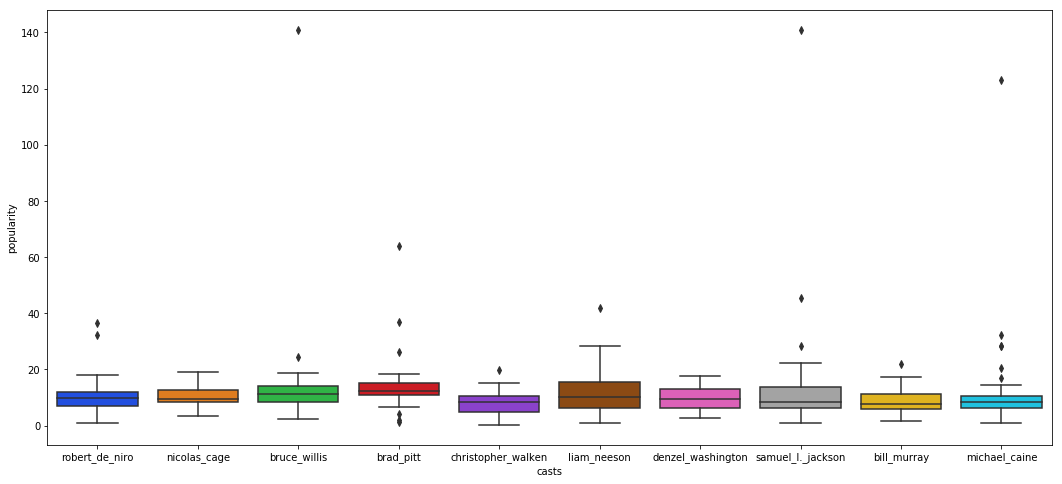

In [27]:
top_casts=['robert_de_niro', 'samuel_l._jackson', 'bruce_willis', 'nicolas_cage', 'michael_caine', 'liam_neeson', 'denzel_washington', 'brad_pitt', 'bill_murray', 'christopher_walken']
plt.figure(figsize=(18,8))
sns.boxplot(x='casts', y='popularity', data=cast_df[(cast_df['casts'].isin(top_casts))], palette="bright")
plt.show()

### keywords

What are the most frequent keywords of movies? The top 3 found here are "independent film", "based on novel" and "woman director." How about the relationship between frequency of keywords and popularity? Popularity of the top 3 common keywords and other three less common keywords are plotted. Results do not show a clear relationship between them.

In [87]:
s = temp.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
key_df = temp.drop('keywords', axis=1).join(s)
key_df['keyword'].value_counts().shape[0]
key_counts = pd.DataFrame(key_df['keyword'].value_counts()).reset_index()
key_counts.columns = ['keyword', 'movies']
key_counts.head()

,keyword,movies
0,independent film,394
1,based on novel,301
2,woman director,272
3,sex,215
4,musical,196


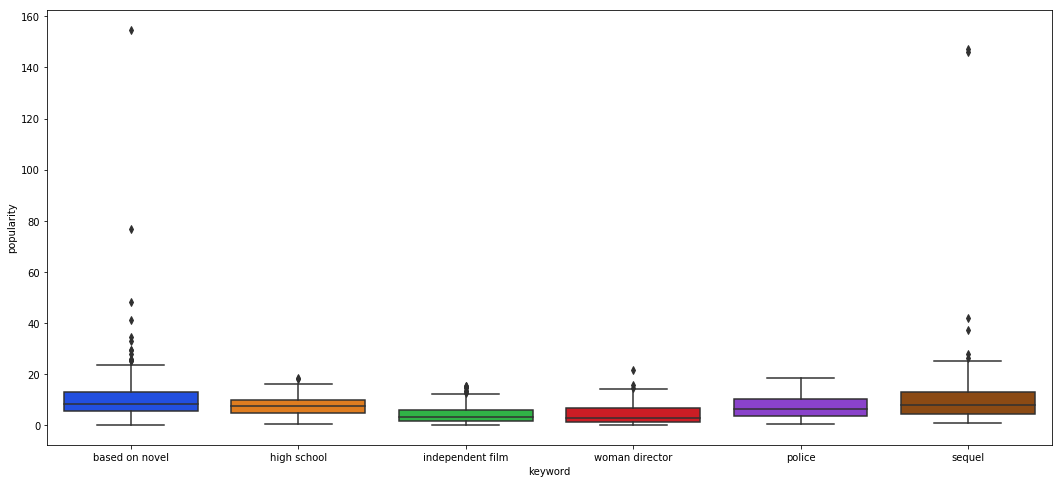

In [29]:
top_keys=['independent film', 'based on novel', 'woman director', 'sequel', 'police', 'high school']
plt.figure(figsize=(18,8))
sns.boxplot(x='keyword', y='popularity', data=key_df[(key_df['keyword'].isin(top_keys))], palette="bright")
plt.show()

## 4. Recommendation Systems

### 4.1 Popularity based system

`Popularity`, `vote_count` and `vote_average` are three of the variables related to popularity. `popularity` and `vote_count` have similar zero-inflated poisson distributions, while the distirbution of `vote_average` is close to a normal distribution. Possibilities are that less popular movies are not definitely receiving low ratings. 

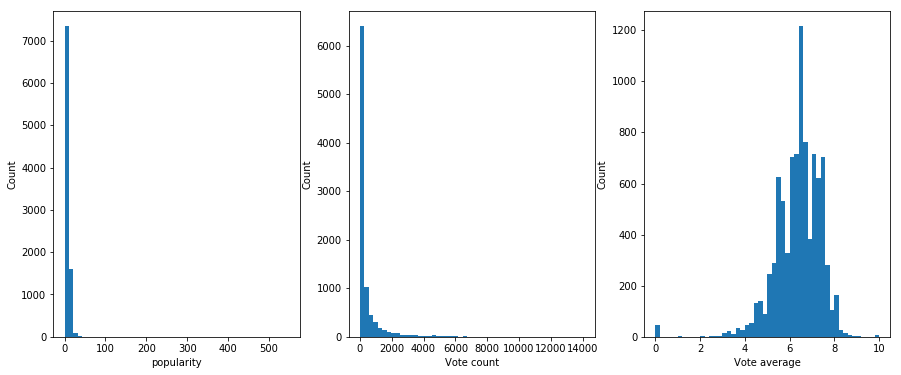

In [30]:
plt.figure(figsize = (15,6))
plt.subplot(1,3,1)
plt.hist(movies['popularity'], bins = 50)
plt.xlabel('popularity')
plt.ylabel('Count');
plt.subplot(1,3,2)
plt.hist(movies['vote_count'], bins=50)
plt.xlabel('Vote count')
plt.ylabel('Count');
plt.subplot(1,3,3)
plt.hist(movies['vote_average'], bins=50)
plt.xlabel('Vote average')
plt.ylabel('Count');
plt.show()

The correlations among them are explored. `vote_count` and `popularity` has a moderate positive correlation with a coefficient of 0.54. 

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


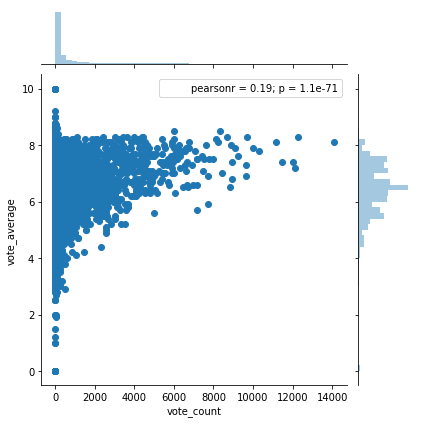

In [31]:
j=sns.jointplot('vote_count', 'vote_average', data=movies)
j.annotate(stats.pearsonr)
plt.show()

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


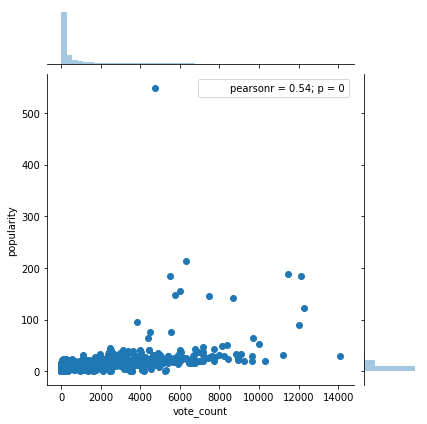

In [32]:
j=sns.jointplot('vote_count', 'popularity', data=movies)
j.annotate(stats.pearsonr)
plt.show()

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


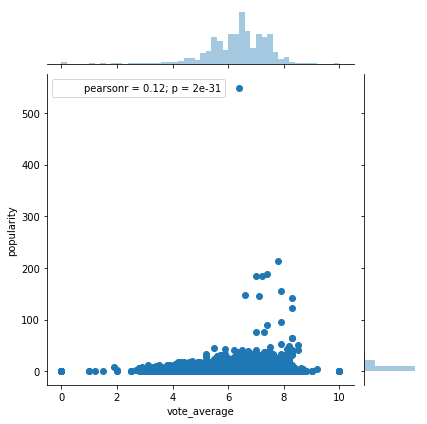

In [33]:
j=sns.jointplot('vote_average', 'popularity', data=movies)
j.annotate(stats.pearsonr)
plt.show()

Popularity based recommendation system is an engine that simply recommends movies to every user based on popularity. That is, suggesting movies with high average ratings to users. Thus, this recommender is not personalized, depending primarily on existing overall ratings. However, this type of recommendation system can provide good options when a user has no preference or idea on which movie to watch. 

In order to build such a recommender, the following notation is introduced. 

Notation:

WR: weighted rating of a movie

R: rating of a movie, i.e. `average_vote`

C: average rating of all movies

v: number of ratings of a movie, i.e. `vote_count`

m: minimal number of ratings for a movie to be considered

Instead of ranking movies only with their own ratings, a weighted rating of a movie, $WR$ is formulated as follows: 

$WR=\frac{v}{v+m}R+\frac{m}{v+m}C$

The weighted rating considers a movie's average rating, its number of ratings as well as the average ratings of all movies. A movie will only be a candidate if its rating count is above a threshold (i.e. $m$). Because a movie with a high average rating might not be an good option if it has few ratings, for example 10 ratings. If a movie has a large volume of ratings, the weight of its own average rating will be high. This implies that the average rating of a movie is more reliable with more ratings. Otherwise, a movie with small amount of ratings, its weighted rating will be more determined by the overall average movie rating. 

In [34]:
# popularity based recommender
def popularity_based(df, quan=0.1, topk=10):
    """
    df: movie pandas dataframe
    quan: the minimal vote count to be considered, 0<=quan<1
    topk: the number of recommended movies
    """
    if 'vote_count' in df.columns and 'vote_average' in df.columns and 'title' in df.columns:
        if quan < 1 and quan >= 0:
            C = df[df['vote_average'].notnull()]['vote_average'].mean() # overall average rating
            m = df[df['vote_count'].notnull()]['vote_count'].quantile(quan) # minimal vote count to consider
            
            # extract qualified subset
            if 'release_date' in df.columns and 'genres' in df.columns: 
                df_sub = df[df['vote_count'] >= m][['title', 'release_date', 'genres','vote_count', 'vote_average']]
                
            else:
                df_sub = df[df['vote_count'] >= m][['title', 'vote_count', 'vote_average']]
            
            # compute weighted rating
            df_sub['wr'] = df_sub.apply(lambda x: x['vote_count']/(x['vote_count']+m)*x['vote_average']+
                                       m/(x['vote_count']+m)*C, axis=1)
            
            # sort movies with weighted rating
            if topk <= len(df_sub):
                return df_sub.sort_values('wr', ascending=False).head(topk)
            else:
                raise Exception("'topk' can not be greater than ", len(df_sub), ".")
                
        else:
            raise Exception("'quan' is required to a non-negative number less than 1.")
    
    else:
        raise Exception("'df' does not contain required columns.")

The ten most popular movies among movies with more than 96 vote counts (i.e. quantile threshold is 0.5) based on weighted ratings have been recommended. The movie: The Shawshank Redemption is the top 1 movie with the highest weighted rating of 8.43.

In [35]:
popularity_based(movies, quan=0.5, topk=10)

,title,release_date,genres,vote_count,vote_average,wr
284,The Shawshank Redemption,1994-09-23,"[drama, crime]",8358.0,8.5,8.475724
692,The Godfather,1972-03-14,"[drama, crime]",6024.0,8.5,8.466466
6897,The Dark Knight,2008-07-16,"[drama, action, crime, thriller]",12269.0,8.3,8.284955
2369,Fight Club,1999-10-15,[drama],9678.0,8.3,8.280967
266,Pulp Fiction,1994-09-10,"[thriller, crime]",8670.0,8.3,8.278778
472,Schindler's List,1993-11-29,"[drama, history, war]",4436.0,8.3,8.258952
8585,Whiplash,2014-10-10,[drama],4376.0,8.3,8.258401
4223,Spirited Away,2001-07-20,"[fantasy, adventure, animation, family]",3968.0,8.3,8.254225
1835,Life Is Beautiful,1997-12-20,"[comedy, drama]",3643.0,8.3,8.250246
973,The Godfather: Part II,1974-12-20,"[drama, crime]",3418.0,8.3,8.247060


### 4.2 Content-based system

Popularity-based recommender system suffers a severe limitation, that is, the system recommends the same movies to everyone without taking user preference into account. A content-based system is proposed to personalize the movies recommended to users. Assume a user would like the movies similar to the movies that he/she likes, the content of a movie, such as genre, plot, director, cast, and keywords, is used to select the movie most similar and recommend to users.

In [36]:
def overview(df, weights):
#     df: movie feature dataframe

#     tf idf for text
    tfidf = TfidfVectorizer(stop_words='english')
    df['text'] = new['overview'] + " " + new['tagline']
    tfidf_matrix = tfidf.fit_transform(df['text'].fillna('')).todense()

    
    return(tfidf_matrix)

In [37]:
tfidf = TfidfVectorizer(stop_words='english')
movies['text'] = movies['overview'] + " " + movies['tagline']
tfidf_matrix = tfidf.fit_transform(movies['text'].fillna('')).todense()

In [38]:
matrix = pd.DataFrame(tfidf_matrix, columns=tfidf.get_feature_names())

In [89]:
top_words = matrix.sum(axis=0).sort_values(ascending=False)
top_words_df = pd.DataFrame(top_words)
top_words_df.head()

,0
life,113.370511
man,101.996009
love,95.952017
new,94.486116
world,90.858007


In [40]:
top_words_df['word'] = top_words_df.index

In [43]:
top=top_words_df['word'].tolist()
# top
# Convert list to string
topstr=" ".join(top[0:1000])

In [44]:
" ".join(top[0:10])

'life man love new world young story family time woman'

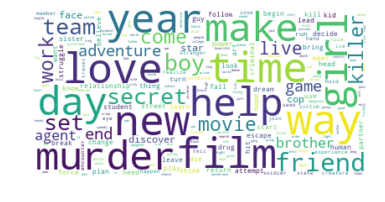

In [45]:
wordcloud = WordCloud(max_font_size=50, background_color="white").generate(topstr)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

People usually prefer different types of movies, directors, actors and/or actresses. From previous analysis, we saw some directors constantly produced a certain type of movies. We also saw some production companies such as Disney and Pixar usually guarantee good animations. 

Two measures of movie similarity are proposed for content-based recommender systems. One is based on movie descriptions, including movie overview and tagline. Term frequency–inverse document frequency(TFIDF) is used to construct a movie-term matrix with each row representing a movie in a term space. In this matrix, cell$(i,j)$ is the frequency of term $j$ appears in movie $i$. Cosine similarity is used to calculate the similarity between each pair of movies. Cosine similarity between two vectors $\mathbf{x}$ and $\mathbf{y}$ is defined as $$\text { similarity }=\cos (\theta)=\frac{\mathbf{x} \cdot \mathbf{y}}{\|\mathbf{x}\|\|\mathbf{y}\|}=\frac{\sum_{i=1}^{n} x_{i} y_{i}}{\sqrt{\sum_{i=1}^{n} x_{i}^{2}} \sqrt{\sum_{i=1}^{n} y_{i}^{2}}}$$

Another way is to use movie meta information such as director, cast, genre, production company. A movie-term matrix is constructed with each term being an instance of a director, cast, genre, production company. The cosine similarity matrix is also computed.

Finally, weights are assigned to these two similarity matrices to get an overall similarity matrix. If a user view history is known, an averaged similarity score for each movie can be computed. The top $k$ most similar movies are therefore recommended.

In [46]:
# # content-based movie similarity
def sim(df, weights):
    """
    df: movie feature dataframe
    weights: weight of two metrics
    """
    
#     tf idf for text
    tfidf = TfidfVectorizer(stop_words='english')
    df['text'] = df['overview'] + " " + df['tagline']
    tfidf_matrix = tfidf.fit_transform(df['text'].fillna(''))
#     Compute the cosine similarity matrix
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    np.fill_diagonal(cosine_sim, 1)
    
#     meta information similarity
    count = CountVectorizer(stop_words='english')
    count_matrix = count.fit_transform(df['features'])
    cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
    
#     combined similarity  
    cosine = weights[0]*cosine_sim + weights[1]*cosine_sim2
    
    return(cosine)

In [47]:
movies.shape

(9082, 16)

In [48]:
# similarity matrix for the dataset
w = [0.4, 0.6]
simMtx = sim(movies, w)

In [49]:
# content-based recommender 
def contentBased(moviels, sim, topk):
    """
    moviels: the movie list that a user watches
    sim: movie similarity matrix
    num: number of movies to recommend
    """

#     find movie index
    ID = movies[movies['title'].isin(moviels)].index.tolist()
    rows = sim[ID]
#     compute average similarity score
    avg_sim = pd.DataFrame({'similarity':rows.mean(axis=0)})
#     from index find movie title and release date
    avg_sim[['title', 'release_date']]= movies[['title', 'release_date']]
    avg_sim = avg_sim[~avg_sim["title"].isin(moviels)]
    avg_sim = avg_sim[["title", 'release_date', "similarity"]]
#     return the top k movies
    recommend = avg_sim.nlargest(topk, 'similarity')
    return(recommend)

In [50]:
contentBased(["Iron Man"], simMtx, 10)

,title,release_date,similarity
7502,Iron Man 2,2010-04-28,0.472780
8280,Iron Man 3,2013-04-18,0.428136
8749,Avengers: Age of Ultron,2015-04-22,0.370273
7864,The Avengers,2012-04-25,0.343247
8750,Ant-Man,2015-07-14,0.324209
8514,Captain America: The Winter Soldier,2014-03-20,0.292904
7818,Captain America: The First Avenger,2011-07-22,0.274320
6960,The Incredible Hulk,2008-06-12,0.268328
8753,Captain America: Civil War,2016-04-27,0.263117
1111,Star Trek III: The Search for Spock,1984-05-31,0.241672


In [51]:
# supterhero
contentBased(["The Avengers", "Iron Man", "Captain America: The First Avenger"], simMtx, 10)

,title,release_date,similarity
8749,Avengers: Age of Ultron,2015-04-22,0.310859
7502,Iron Man 2,2010-04-28,0.304215
8514,Captain America: The Winter Soldier,2014-03-20,0.288419
8280,Iron Man 3,2013-04-18,0.265760
8750,Ant-Man,2015-07-14,0.257600
6960,The Incredible Hulk,2008-06-12,0.246516
8753,Captain America: Civil War,2016-04-27,0.239698
3028,X-Men,2000-07-13,0.208098
8409,Thor: The Dark World,2013-10-29,0.203199
4579,X2,2003-04-24,0.202876


In [52]:
# disney 
contentBased(["Inside Out", "Frozen", "Tangled", "Peter Pan"], simMtx, 5)

,title,release_date,similarity
521,Aladdin,1992-11-25,0.219991
216,Gumby: The Movie,1995-12-01,0.212915
1242,Hercules,1997-06-26,0.212854
3946,Return to Never Land,2002-02-14,0.205518
2730,Creature Comforts,1989-07-15,0.203238


In [53]:
# Nolan
contentBased(["Inception", "Interstellar", "The Dark Knight"], simMtx, 5)

,title,release_date,similarity
7926,The Dark Knight Rises,2012-07-16,0.320941
6141,Batman Begins,2005-06-10,0.271341
8307,Man of Steel,2013-06-12,0.217003
6444,Superman Returns,2006-06-28,0.191557
6985,Watchmen,2009-03-05,0.183402


### 4.3 Collaborative filtering 

How are the rating distributed? The mode of rating is about 4. The shape is kind of left-skewed. 

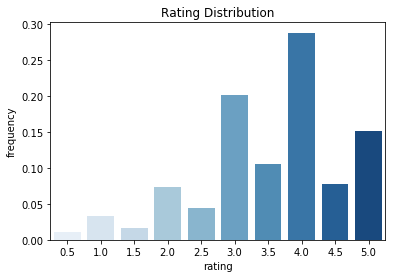

In [54]:
rating_count = (
    ratings['rating'].
    value_counts(normalize = True, sort=False).
    reset_index().
    rename(columns = {'index' : 'rating', 'rating': 'frequency'})
)

ax = sns.barplot(x = 'rating', y = 'frequency',palette = 'Blues',data = rating_count)
ax.set_title('Rating Distribution')
plt.show()

The histogram of users' ratings show that a user usually has very limited number of movie ratings.

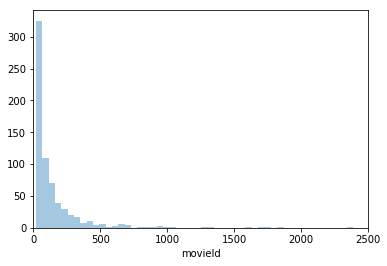

In [55]:
g = sns.distplot(ratings.groupby('userId')['movieId'].count(), kde = False, bins = 50)
g.set(xlim = (0,2500));

How many ratings were submitted per year? The year of 2000 witnessed the highest amount of ratings and there are only 11 ratings in 1995. Most years have rating amount ranging from 10,000 to 30,000.

,year,rating
0,1995,11.0
1,1996,22436.0
2,1997,11945.0
3,1998,6523.0
4,1999,21852.0
5,2000,50750.0
6,2001,16309.0
7,2002,13075.0
8,2003,15382.0
9,2004,15821.0


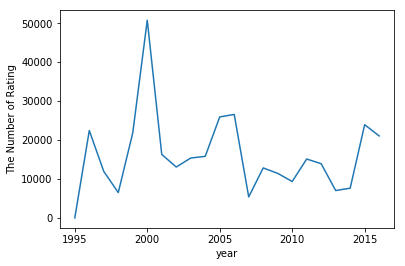

In [56]:
import calendar
rating_time = ratings.groupby(['year'])['rating'].sum()
rating_time = rating_time.reset_index(level=0)
display(rating_time)

ax = sns.lineplot(x = 'year', y = 'rating',data = rating_time, sort = False)
ax.set_ylabel('The Number of Rating')
plt.xticks();

Average rating score of each year is approximately constant over the time.

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


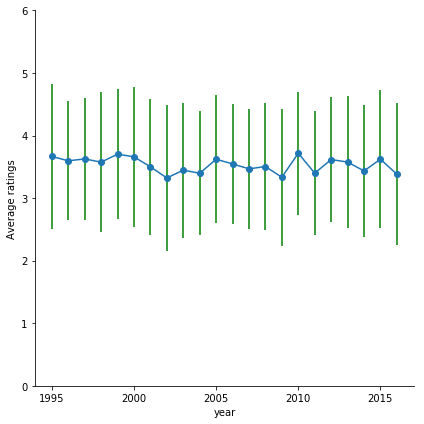

In [57]:
rating_avg = ratings.groupby(['year'])['rating'].agg([np.mean, np.std])
rating_avg = rating_avg.reset_index(level = 0)
#display(rating_avg)

g = sns.FacetGrid(rating_avg, size=6, ylim = (0,6))
ax = g.map(plt.errorbar,'year', 'mean', 'std', marker="o", ecolor = 'green')
ax.set(xlabel = 'year', ylabel = 'Average ratings')
plt.xticks();

The number of movies prodcued is significantly increasing.

,userId,movieId,rating,timestamp,year,month,Date
52635,383,21,3.0,1995-01-09 11:46:49,1995,1,1995-01-01
52641,383,47,5.0,1995-01-09 11:46:49,1995,1,1995-01-01
52684,383,1079,3.0,1995-01-09 11:46:49,1995,1,1995-01-01
56907,409,21,5.0,1996-03-30 19:00:12,1996,3,1996-03-01
56909,409,25,4.0,1996-03-30 19:00:12,1996,3,1996-03-01


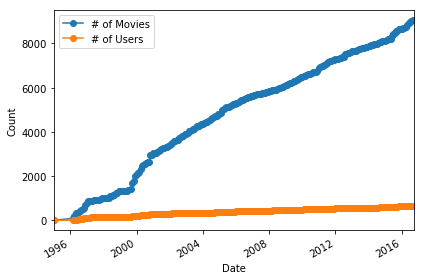

In [57]:
ratings['Date'] = ratings[['year', 'month']].apply(
    lambda x: datetime(year=int(x[0]), month=int(x[1]), day=1), axis=1
)
display(ratings.head())
n_users = []
n_movies = []
dates = np.unique(ratings['Date'])
for date in dates:
    n_users.append(ratings[ratings['Date'] <= date]['userId'].nunique())
    n_movies.append(ratings[ratings['Date'] <= date]['movieId'].nunique())
df_users = pd.DataFrame({'Date': dates, '# of Users': n_users}).set_index('Date')
df_movies = pd.DataFrame({'Date': dates, '# of Movies': n_movies}).set_index('Date')
fig, ax = plt.subplots()
df_movies['# of Movies'].plot(style='o-', ax=ax)
df_users['# of Users'].plot(style='o-', ax=ax)
plt.ylabel('Count')
ax.grid(which='minor')
plt.tight_layout()
plt.legend()
plt.show()

What is the sparsity of rating matrix?

In [58]:
rating_sum = {'Total number of rating': ratings['rating'].count(), 
              'Total number of user':ratings['userId'].nunique(),
              'Total number of movie' : ratings['movieId'].nunique(),
              'Maximum rating': ratings['rating'].max(),
              'Minimum rating': ratings['rating'].min(),
              'Maximum number of rating from a user': ratings.groupby('userId')['rating'].count().max(),
              'Maximum number of recevied rating from a movie':ratings.groupby('movieId')['rating'].count().max()}
pd.Series(rating_sum)

Total number of rating                            100004.0
Total number of user                                 671.0
Total number of movie                               9066.0
Maximum rating                                         5.0
Minimum rating                                         0.5
Maximum number of rating from a user                2391.0
Maximum number of recevied rating from a movie       341.0
dtype: float64

The maximal number of movie ratings from a single user is 2391 which is less than the total number of movies. This indicates that no one rated all movies in the given dataset.The maximal ratings that a movie receive is 341 that is less than the number of users. This indicates every single movie is not rated by every user. In addition, usually, a user would rate a very limited number of movies. Collectively, these facts reveal that the rating matrix is a sparse matrix. Therefore, matrix sparsity has to be solved in collaborative filtering.

The sparsity is defined as $$\rm{Sparsity} = 1 - \frac{\rm{Number \ of \ ratings}}{\rm{Number \ of \ users * Number \ of \ movies}}$$

The sparsity of the given dataset is about 98.36%.  

In [59]:
1 - ratings['rating'].count() / (ratings['userId'].nunique() * ratings['movieId'].nunique())

0.9835608583913366

Assume a rating matrix $R$ with dimensions of $n\times m$ where $n$ is the number of users, $m$ is the number of movies and each cell $r_{ui}$ is the rating of movie $i$ by user $u$. The plot below is an illustration of the matrix $R$. The plot shows the sparsity of $R$ as well as old movies (usually with small movie id's) received more ratings.

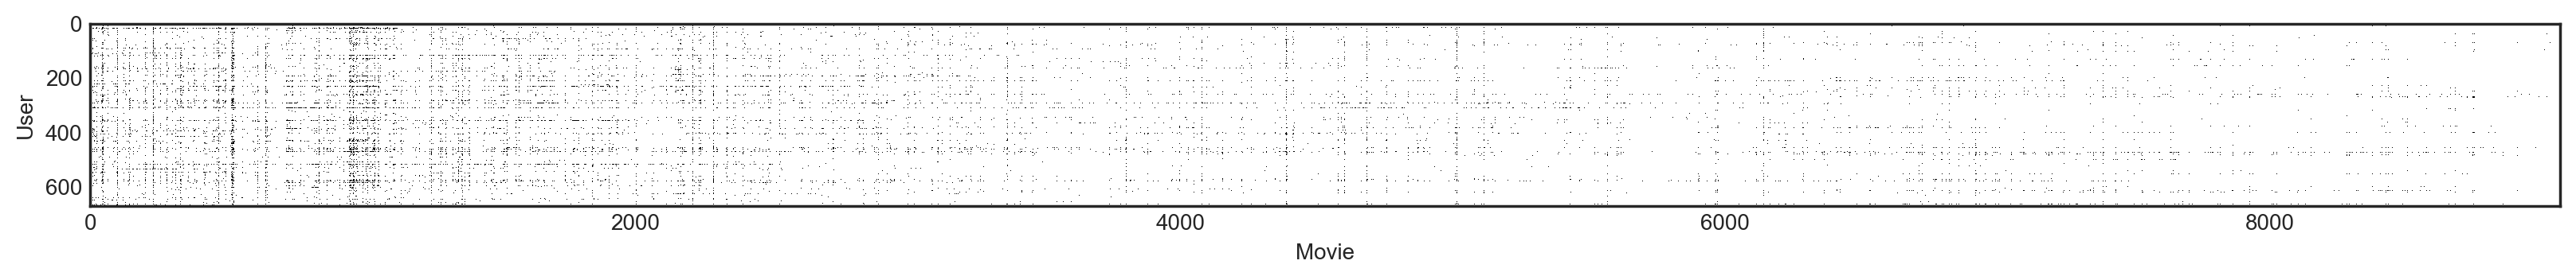

In [60]:
rating_matrix = (
        pd.pivot_table(
            data=ratings,
            values='rating',
            index='userId',
            columns='movieId',
        )
        .fillna(0)
        .values
    )
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 10), dpi=200, facecolor='w', edgecolor='k')

with plt.style.context('seaborn-white'):
    rating_matrix_binary = rating_matrix > 0
    plt.imshow(rating_matrix_binary)
    plt.xlabel('Movie')
    plt.ylabel('User')
    plt.show()

The idea of collaborative filtering recommendation systems is recommending items based on customers' previous behaviors patterns. A collaborative filtering recommender requires historical information about the interaction between a user and items. Rating scores of movies that a user never watched is predicted and then movies are recommended based on predicted scores.

#### Step 1. Matrix factorization (Singular value decompostion)

Shown in the following figure, a rating matrix is decomposed as a user matrix (denote as $p$) and an item matrix (denote as $q$) by SVD.

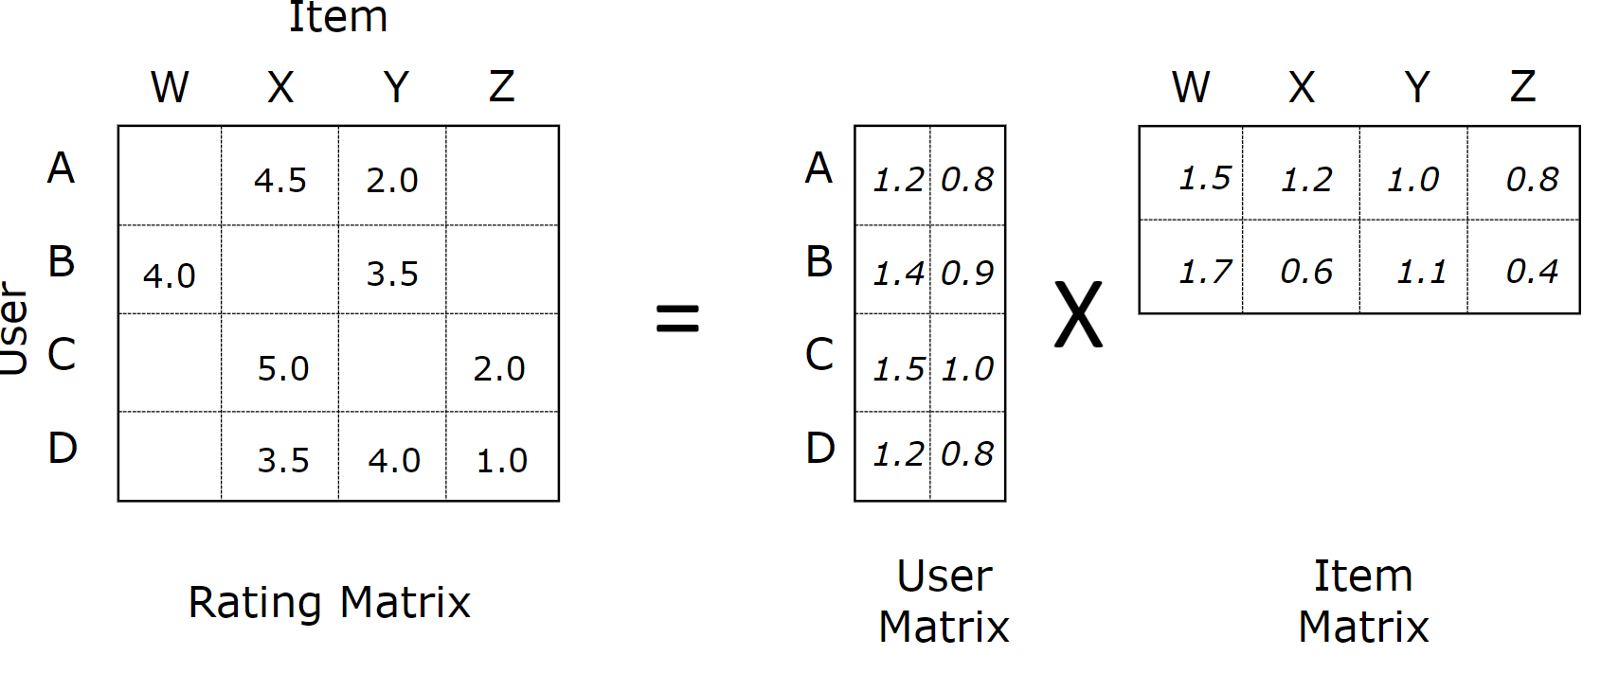

In [62]:
Image(filename='svd.png')

Mathmatically,

$$R = p^T \cdot q$$

Where, 


$R$ is the rating matrix

$p$ is the user matrix with dimension $n\times f$, $n$ is number of users and $f$ is number of features

$q$ is the item matrix with dimension $f\times m$, $m$ is number of movie and $f$ is number of features


In the estimated $R$ matrix, the predicted rating score of movie $i$ by user $u$ is:

$$\hat{r}_{ui} =  p_u^T \cdot q_i$$

The estimation error is defined as:

$$e_{ui} = r_{ui} - \hat{r}_{ui}$$

The SSE is defined as:

$$SSE = \sum_{u,i}{e_{ui}^2} = \sum_{u,i}{(r_{ui} - \hat{r}_{ui}})^2$$ 

#### Step 2. Optimizing parameters  by stochastic gradient descent (SGD)

The predicted rating $r_{ui}$ is defined as:  

$$\hat{r}_{ui} = \mu + b_u + b_i + p_u^T \cdot q_i$$

Where,

$\mu$ is the overall average rating score,
$b_u$ is the bias of user $u$ and $b_i$ is the bias of movie $i$.

The loss function, with penality foroverfitting, is introduced:
$$
L = \sum_{u,i}(r_{ui} - \hat{r}_{ui})^2 +
  \lambda_{b_u} \sum_u \lVert b_u \lVert^2 +
  \lambda_{b_i} \sum_i \lVert b_i \lVert^2 +
  \lambda_{p_u} \sum_u \lVert \mathbf{p}_u \lVert^2 +
  \lambda_{q_i} \sum_i \lVert \mathbf{q}_i \lVert^2
$$


SGD is used to seek for optimal parameters that minimize the loss function. The proof can be found for [here](https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea#d42b). In each iteration, $b_u$, $b_i$, $p_u$, $q_i$ will be updated:

$$
b_u^{t+1} = b_u^{t} + \eta (e_{ui} - \lambda_{b_u}b_u) \\
b_i^{t+1} = b_i^{t} + \eta (e_{ui} - \lambda_{b_i}b_i) \\
\mathbf{p}_u^{t+1} = \mathbf{p}_u^{t} + \eta (e_{ui} \mathbf{q}_i - \lambda_{p_u} \mathbf{p}_u) \\
\mathbf{q}_i^{t+1} = \mathbf{q}_i^{t} + \eta (e_{ui} \mathbf{p}_u - \lambda_{q_i} \mathbf{q}_i) \\
$$

where $\eta$ is the learning rate (a parameter that controls the speed of descent down the gradients) and $e_{ui}$ is the prediction error given by $\hat{r}_{ui} - r_{ui}$.


After certain iterations, it is possible to get optimal $b_u$, $b_i$, $p_u$, $q_i$. Thus, for each $u$ and $i$, we are able to estimate the predicted rating. The performance is evaluated by RMSE:

$$RMSE = \sqrt{\frac{1}{n} \sum_{i = 1}^{n}(r_{i} - \hat{r}_{i})^2}$$

Where 

$r_i$ is the true rating score;  $\hat{r}_{i}$ is the predicted rating score.

In the given dataset, each user has rated at least 20 movies which results in a reasonable sparsity of 98.36%. This means that 98.36% of the user-item ratings are missing. The data is split into training and test sets by extracting 10 ratings per user to creat the test set. 

In [63]:
import random
import numpy as np
# set seed
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

reader = Reader()
# Load the movie data
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
all_data = data.raw_ratings

# split our data into training and test sets by removing 10 ratings per user in the training set
# put 10 ratings in the testing set
testing = (ratings.groupby('userId').
                apply(lambda obj: obj.loc[np.random.choice(obj.index, size = 10, replace = False),:]))
training = ratings.drop(list(testing.reset_index(level = 0, drop = True).index))

# read data in the suprise format
training_set = Dataset.load_from_df(training[['userId', 'movieId', 'rating']], reader).build_full_trainset()
testing_set = Dataset.load_from_df(testing[['userId', 'movieId', 'rating']], reader)

Using the Grid Search on training set, the optimal parameters and corresponding RMSE on training set and testing set can be obtained.

In [85]:
# Select your best algo with grid search.
print('Grid Search...')
param_grid = {'n_epochs': [10, 15, 20], 
              'lr_all': [0.005, 0.01, 0.1], 
              'reg_bu': [0.001, 0.02],
              'reg_bi': [0.001, 0.02],
              'reg_pu': [0.01, 0.05], 
              'reg_qi': [0.01, 0.05]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
grid_search.fit(data)

gs_algo = grid_search.best_estimator['rmse']

# Fit the training data
gs_algo.fit(training_set)

# Compute the RMSE on the training set
gs_predictions = gs_algo.test(trainset.build_testset())
print('Biased accuracy on Training set,', end='   ')
accuracy.rmse(predictions)

# Compute THE RMSE on the testing set
testset = data.construct_testset(testing_set.raw_ratings) 
gs_predictions = algo.test(testset)
print('Unbiased accuracy on Testing set,', end=' ')
accuracy.rmse(predictions);

Grid Search...
Biased accuracy on Training set,   RMSE: 0.5364
Unbiased accuracy on Testing set, RMSE: 0.5364


In [86]:
grid_search.best_params

{'rmse': {'n_epochs': 20,
  'lr_all': 0.01,
  'reg_bu': 0.02,
  'reg_bi': 0.02,
  'reg_pu': 0.05,
  'reg_qi': 0.05}}

In [64]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [66]:
# First train an SVD algorithm on the movielens dataset.
trainset = data.build_full_trainset()
algo = SVD(n_epochs= 20, lr_all= 0.01, reg_bu= 0.02, reg_bi= 0.02, reg_pu= 0.05,reg_qi= 0.05)
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

# get all top 10 movies for each user
top_n = get_top_n(predictions, n=10)

In [69]:
def recommender(user_id, top_num = 10):
    global top_n
    
    # create the dataframe
    result = pd.DataFrame(top_n.get(user_id), columns = ['movie_id', 'estimated_rating_score'])
    result['title']= movies.iloc[result.index.values]['title'].tolist()
    result = result[['title', 'estimated_rating_score']]
    
    return result

For a user with ID 308, based on his/her preferences, recommended movies are:

In [70]:
recommender(308)

,title,estimated_rating_score
0,Toy Story,4.947245
1,Jumanji,4.685178
2,Grumpier Old Men,4.680560
3,Waiting to Exhale,4.656898
4,Father of the Bride Part II,4.654641
5,Heat,4.635356
6,Sabrina,4.632835
7,Tom and Huck,4.599471
8,Sudden Death,4.595937
9,GoldenEye,4.580992


#### Test performaces under different parameters in the training set and testing set:

In [71]:
# test for different factors
test_factors = []
for n in range(2,120,10):
    test_algo = SVD(n_epochs= 20, n_factors = n, lr_all= 0.01, reg_bu= 0.02, reg_bi= 0.02, 
                    reg_pu= 0.05,reg_qi= 0.05, random_state = 5)
    test_algo.fit(training_set)
    
    # Compute the RMSE on the testing set
    testset = data.construct_testset(testing_set.raw_ratings) 
    test_pred = test_algo.test(testset)
    print('Unbiased accuracy on Testing set,', end=' ')
    test_factors.append(accuracy.rmse(test_pred));

Unbiased accuracy on Testing set, RMSE: 0.9213
Unbiased accuracy on Testing set, RMSE: 0.9178
Unbiased accuracy on Testing set, RMSE: 0.9135
Unbiased accuracy on Testing set, RMSE: 0.9145
Unbiased accuracy on Testing set, RMSE: 0.9153
Unbiased accuracy on Testing set, RMSE: 0.9125
Unbiased accuracy on Testing set, RMSE: 0.9089
Unbiased accuracy on Testing set, RMSE: 0.9142
Unbiased accuracy on Testing set, RMSE: 0.9125
Unbiased accuracy on Testing set, RMSE: 0.9101
Unbiased accuracy on Testing set, RMSE: 0.9125
Unbiased accuracy on Testing set, RMSE: 0.9145


The plot shows that 60 is the optimal number of features for a minimal $RMSE$.

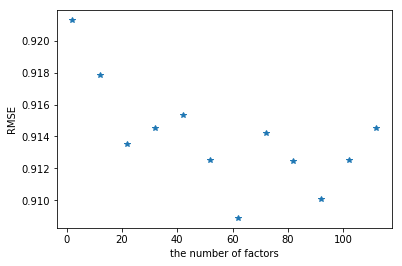

In [72]:
plt.plot(list(range(2,120,10)), test_factors, '*')
plt.xlabel('the number of factors')
plt.ylabel('RMSE');

$RMSE$ would not decrease after 18 epoches in the testing set and keep decreasing with increasing epoches.

In [73]:
tran_epoches = []
test_epoches = []
for n in range(0,100,10):
    test_algo = SVD(n_epochs= n, n_factors = 100, lr_all= 0.01, reg_bu= 0.02, reg_bi= 0.02, 
                    reg_pu= 0.05,reg_qi= 0.05, random_state = 5)
    test_algo.fit(training_set)
    
    # Compute the RMSE on the training set
    tran_pred = test_algo.test(trainset.build_testset())
    print('Biased accuracy on Training set,', end='   ')
    tran_epoches.append(accuracy.rmse(tran_pred))
    
    # Compute THE RMSE on the testing set
    testset = data.construct_testset(testing_set.raw_ratings) 
    test_pred = test_algo.test(testset)
    print('Unbiased accuracy on Testing set,', end=' ')
    test_epoches.append(accuracy.rmse(test_pred));

Biased accuracy on Training set,   RMSE: 1.0631
Unbiased accuracy on Testing set, RMSE: 1.0847
Biased accuracy on Training set,   RMSE: 0.7742
Unbiased accuracy on Testing set, RMSE: 0.9250
Biased accuracy on Training set,   RMSE: 0.6162
Unbiased accuracy on Testing set, RMSE: 0.9147
Biased accuracy on Training set,   RMSE: 0.5194
Unbiased accuracy on Testing set, RMSE: 0.9132
Biased accuracy on Training set,   RMSE: 0.4697
Unbiased accuracy on Testing set, RMSE: 0.9136
Biased accuracy on Training set,   RMSE: 0.4422
Unbiased accuracy on Testing set, RMSE: 0.9138
Biased accuracy on Training set,   RMSE: 0.4257
Unbiased accuracy on Testing set, RMSE: 0.9138
Biased accuracy on Training set,   RMSE: 0.4151
Unbiased accuracy on Testing set, RMSE: 0.9137
Biased accuracy on Training set,   RMSE: 0.4078
Unbiased accuracy on Testing set, RMSE: 0.9135
Biased accuracy on Training set,   RMSE: 0.4027
Unbiased accuracy on Testing set, RMSE: 0.9132


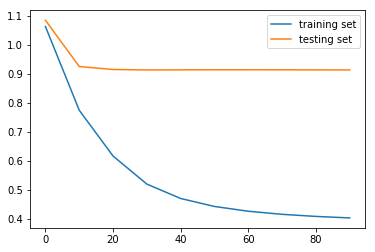

In [74]:
plt.plot(list(range(0,100,10)), tran_epoches, label='training set')
plt.plot(list(range(0,100,10)), test_epoches, label='testing set')
plt.legend()
plt.show()

### 4.4 Hybrid system

Considering the fact that each recommender has its own strengths and weaknesses, a hybrid system that incorporates popularity-based, content-based and collaborative filtering recommenders is built. With an input user information containing the user and his/her movie ratings, the system will compute three scores using these three recommenders and then calculate a weighted score based on given weights. Then, movies are recommended based on weighted scores.

The following "popularity" function is operating basically the same as the popularity recommender in Section 3 with minor changes in input and output for the convenience of building the hybrid system. Same for "content_base" and "SGD" function below.

In [75]:
# popularity based recommender for hybrid recommender
def popularity(df, m):
    """
    df: movie pandas dataframe
    quan: the minimal vote count to be considered, 0<=quan<1
    topk: the number of recommended movies
    """
    if 'vote_count' in df.columns and 'vote_average' in df.columns and 'title' in df.columns:

        C = df[df['vote_average'].notnull()]['vote_average'].mean() # overall average rating
        # m = df[df['vote_count'].notnull()]['vote_count'].quantile(quan) # minimal vote count to consider

        # extract qualified subset
        if 'release_date' in df.columns and 'genres' in df.columns: 
            df_sub = df[['id', 'title', 'release_date', 'genres','vote_count', 'vote_average']]
        else:
            df_sub = df[['id', 'title', 'vote_count', 'vote_average']]

        # compute weighted rating
        df_sub['wr'] = df_sub.apply(lambda x: x['vote_count']/(x['vote_count']+m)*x['vote_average']+
                                   m/(x['vote_count']+m)*C, axis=1)

        # sort movies with weighted rating
        return df_sub.sort_values('wr', ascending=False)
                  
    else:
        raise Exception("'df' does not contain required columns.")

In [76]:
def content_based(user):
    #     find movie index
    ID = movies[movies['title'].isin(list(user[1].keys()))].index.tolist()
    rows = simMtx[ID]
#     compute average similarity score
    avg_sim = pd.DataFrame({'sim':rows.mean(axis=0)})
#     from index find movie title and release date
    avg_sim[['movieID']]= movies[['id']]
    return avg_sim

In [77]:
# set seed
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

def SGD(user1):
    
    global movies
    global ratings
    
    reader = Reader()
    user_id = user1[0]
    m_id = ratings.movieId.unique()
    
    
    if user_id in ratings.userId.unique():
        
        data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
        trainset = data.build_full_trainset()
        algo = SVD(n_epochs= 20, lr_all= 0.01, reg_bu= 0.02, reg_bi= 0.02, reg_pu= 0.05,reg_qi= 0.05)
        algo.fit(trainset)
        result = [algo.predict(user_id, i, verbose=False) for i in m_id]
        
        return result
        
        
    else:
        
        keys = list(user1[1].keys())
        # find the all titles in movies dataframe
        movies_revised = movies.loc[movies.title.drop_duplicates().index]
        movies_id = movies_revised.id[movies_revised.title.isin(keys)]

        # get all possible ratings in links_small
        link_id = link['movieId'][link['tmdbId'].isin(movies_id)]
        final_id = list(m_id[pd.Series(m_id).isin(link_id)])
        final_key = combine_df[combine_df.movieId.isin(final_id)].title
        final_value = [user1[1].get(key) for key in final_key]
        n = len(final_value)

        # form the dataframe
        user_df = pd.DataFrame({'userId' : [user_id] * n, 
                                 'movieId' : final_id, 
                                 'rating':  final_value})
        if user_df.shape[0] == 0:
            result = str('No available movies in dataset!')
            return(result)
            
        else:
        
            # combine together
            new_df = pd.concat([user_df, ratings.iloc[:, 0:3]])
            # fit into suprise dataframe
            new_data = Dataset.load_from_df(new_df[['userId', 'movieId', 'rating']], reader).build_full_trainset()


            # set the algorithm
            algo1 = SVD(n_epochs= 20, lr_all= 0.01, reg_bu= 0.02, reg_bi= 0.02, reg_pu= 0.05,reg_qi= 0.05)
            algo1.fit(new_data)

            #if user_id in ratings.userId.unique():
            result = [algo1.predict(user_id, i, verbose=False) for i in m_id]

            return pd.DataFrame(result)

In [78]:
def hybrid(user, weights=[1,0,0], topk=10):
    """
    user: user data
    quan: the minimal vote count to be considered, 0<=quan<1
    topk: the number of recommended movies
    weights: [w1, w2, w3], weight for each recommender
    """
    
    # popularity based
    quan = 0.2
    m = movies[movies['vote_count'].notnull()]['vote_count'].quantile(quan)
    pop = popularity(movies, m)
    # standarize
    pop['wr'] = (pop['wr']-pop['wr'].min())/(pop['wr'].max()-pop['wr'].min())
    # if vote_count<m, popularity score=0
    pop.loc[pop['vote_count']<m, 'wr']=0
    
    # content based
    content = content_based(user)
    content['sim'] = (content['sim']-content['sim'].min())/(content['sim'].max()-content['sim'].min())
    
    # collaborative filtering
    cf = pd.DataFrame(SGD(user))
    cf['est'] = (cf['est']-cf['est'].min())/(cf['est'].max()-cf['est'].min())
    
    # put three scores together
    scores = pop.copy()
    scores = scores.merge(content, left_on='id', right_on='movieID', how="left")
    cf = cf.merge(combine_df, left_on='iid', right_on='movieId', how="left")
    scores = cf.merge(scores, right_on='movieID', left_on='tmdbId')
    scores = scores[['title_y', 'release_date', 'wr', 'sim', 'est']]
    # weighted score
    scores['score'] = weights[0]*scores['wr']+weights[1]*scores['sim']+weights[2]*scores['est']
    scores.rename(columns={'title_y':'title', 'wr': 'popularity', 'sim': 'similarity', 'est': 'collaborative'},inplace=True)
    # filter out watched movie
    scores = scores[~scores["title"].isin(list(user[1].keys()))]
    
    return scores.sort_values('score', ascending=False).head(topk)

#### An interactive interface demo

In [79]:
import ipywidgets as widgets

Hypothetical user information is created to test the proposed hybrid recommendation system.

In [80]:
# test data
user1 = [12324, {"The Avengers": 4, "Iron Man":3.5, "Captain America: The First Avenger": 4}]
user2 = [124354, {"Inside Out": 4, "Frozen":3, "Tangled": 4, 'Peter Pan': 3.5, 'Dead Man Walking': 2}]
user3 = [233333, {"Inception": 4, "Interstellar":3, "The Dark Knight": 4}]
users = [user1, user2, user3]
weights = [[1,0,0], [0,1,0], [.33, .33, .34]]

In [81]:
menu = widgets.Dropdown(
    options=[('1', 0), ('2', 1), ('3', 2)],
    value=0,
    description='User:',
    disabled=False
)

menu2 = widgets.Dropdown(
    options=[('(1,0,0)', 0), ('(0,1,0)', 1), ('(0.33, 0.33, 0.34)', 2)],
    value=1,
    description='Weights:',
    disabled=False
)

num = widgets.IntText(
    value=5,
    description='Top k:',
    disabled=False
)

ui = widgets.HBox([menu, menu2, num])

In [82]:
def f1(menu, menu2, num):
    pd.set_option('display.max_columns', None)
    df = hybrid(users[menu], weights[menu2], num)
    print("User " + str(menu+1) + ": ", users[menu], "\n", df)

out = widgets.interactive_output(f1, {'menu': menu, 'menu2': menu2, 'num': num})

display(ui, out)

Output()

## 5. Conclusions

This project is interested in constructing an informative movie recommender system to provide valuable movie suggestion tailored to specific users but also considering movie contents and popularity. Exploratory data analysis is conducted to investigate the movie and user rating datasets. The data are also pre-processed and cleaned. A popularity-based recommendation system is constructed to primarily consider movie popularity. Movies with similar contents are recommended by a content-based recommender. A collaborative filtering system is created to suggest movies by predicting missing users’ ratings. Finally, a hybrid system combining the above three systems through customized weights is proposed. 

Experimental results show that the proposed recommender can offer meaningful movie recommendations based on a user’s preference on movie popularity, contents and ratings. 


## References

Ahmed, I. (February 2019). The Age of Recommender Systems. Retrieved June 8, 2019 from https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system.

Banik, R. (June 2017). Movies Recommender System. Retrieved June 8, 2019 from https://www.kaggle.com/rounakbanik/movie-recommender-systems

Daniel, F. (July 2017). Film recommendation engine. Retrieved June 8, 2019 from https://www.kaggle.com/fabiendaniel/film-recommendation-engine.

Ghosh, S. (Mar 2018). Simple Matrix Factorization example on the Movielens dataset using Pyspark. Retrieved June 8, 2019 from https://medium.com/@connectwithghosh/simple-matrix-factorization-example-on-the-movielens-dataset-using-pyspark-9b7e3f567536

The Movies Dataset. (2017).  Retrieved June 8, 2019 from https://www.kaggle.com/rounakbanik/the-movies-dataset.

Akshi Kumar & Abhilasha Sharma (2013). Alleviating Sparsity and Scalability Issues in Collaborative Filtering Based Recommender Systems, Part of the Advances in Intelligent Systems and Computing book series (AISC, volume 199)